In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [28]:
import os
import numpy as np
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt  # at top of file


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

# Hugging Face dataset library
from datasets import load_dataset

import timm


In [29]:
# -------------------------------
# Dataset Wrapper
# -------------------------------
class DeepfakeDataset(Dataset):
    """
    A custom Dataset wrapper for deepfake images.
    It assumes that the HF dataset has keys "image" and "label".
    """
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        # Get the image and its label from the Hugging Face dataset
        # (modify keys if needed based on the actual dataset structure)
        sample = self.hf_dataset[idx]
        image = sample['image']
        # Convert the image to a PIL Image if it is not one
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        label = sample['label']  # assuming labels are stored as 'label'
        if self.transform:
            image = self.transform(image)
        return image, label


In [30]:
# -------------------------------
# Transformations for different model inputs
# -------------------------------
# For Model A and Model B, we use small images (50x50)
transform_small = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# For Model C, we use larger images (224x224)
transform_large = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# -------------------------------
# Model Definitions
# -------------------------------


In [31]:

# --- Model A: CNN-based network for eye and nose regions (12 layers) ---
class ModelA(nn.Module):
    def __init__(self, num_classes=2):
        super(ModelA, self).__init__()
        # Three convolutional blocks, each with 2 conv layers + BN, ReLU, pooling and dropout
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)
        )
        # After three blocks, feature map size for 50x50 input: 50 -> 25 -> ~12 -> ~6
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x


In [32]:

# --- Model B: Simpler CNN-based network (6 layers) ---
class ModelB(nn.Module):
    def __init__(self, num_classes=2):
        super(ModelB, self).__init__()
        # A lighter CNN architecture: three conv layers with pooling and dropout
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [33]:
# --- Model C: CNN + ViT based network for the entire face ---
class ModelC(nn.Module):
    def __init__(self, num_classes=2):
        super(ModelC, self).__init__()
        # Feature learning (FL) module: a deep CNN.
        # For demonstration, we use a simpler CNN here.
        self.cnn_feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Assume feature map size is reduced appropriately (for 224x224, it becomes roughly 28x28)
        # Now use a vision transformer module from the timm library.
        # Note: You may need to install timm (pip install timm).
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        # Replace the head of ViT to match our number of classes.
        in_features = self.vit.head.in_features
        self.vit.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # Extract lower-level features (optional fusion)
        features = self.cnn_feature_extractor(x)
        # For this demonstration, we are feeding the original image to vit.
        # In a more advanced implementation, you can fuse the CNN features with ViT.
        out = self.vit(x)
        return out


# -------------------------------
# Training and Evaluation Functions
# -------------------------------

In [34]:

def train_model(model, dataloader, criterion, optimizer, device, num_epochs=5):
    model.train()
    loss_history = []
    acc_history  = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc  = correct / total
        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)
        print(f"Epoch {epoch+1}/{num_epochs} — Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

    return model, loss_history, acc_history


In [36]:
def evaluate_model(model, dataloader, device):
    model.eval()
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.numpy())
    return np.array(preds_all), np.array(labels_all)

In [37]:
def majority_vote(predictions_list):
    """Combine predictions (list of numpy arrays) via majority voting."""
    # predictions_list should be a list of arrays with same length.
    predictions_list = np.array(predictions_list)  # shape: [n_models, n_samples]
    final_preds = []
    for preds in predictions_list.T:
        # Compute the majority vote for each sample.
        vote = Counter(preds).most_common(1)[0][0]
        final_preds.append(vote)
    return np.array(final_preds)

Using device: cuda
Training Model A (CNN-based - Model A, 12 layers, small images)...
Epoch 1/10 — Loss: 0.3871, Acc: 0.8163
Epoch 2/10 — Loss: 0.2458, Acc: 0.8953
Epoch 3/10 — Loss: 0.1972, Acc: 0.9184
Epoch 4/10 — Loss: 0.1662, Acc: 0.9317
Epoch 5/10 — Loss: 0.1490, Acc: 0.9395
Epoch 6/10 — Loss: 0.1339, Acc: 0.9463
Epoch 7/10 — Loss: 0.1236, Acc: 0.9505
Epoch 8/10 — Loss: 0.1151, Acc: 0.9542
Epoch 9/10 — Loss: 0.1083, Acc: 0.9565
Epoch 10/10 — Loss: 0.1022, Acc: 0.9590
Training Model B (Simpler CNN-based - Model B, small images)...
Epoch 1/10 — Loss: 0.4825, Acc: 0.7608
Epoch 2/10 — Loss: 0.3833, Acc: 0.8236
Epoch 3/10 — Loss: 0.3323, Acc: 0.8504
Epoch 4/10 — Loss: 0.2963, Acc: 0.8694
Epoch 5/10 — Loss: 0.2692, Acc: 0.8823
Epoch 6/10 — Loss: 0.2499, Acc: 0.8925
Epoch 7/10 — Loss: 0.2330, Acc: 0.9000
Epoch 8/10 — Loss: 0.2214, Acc: 0.9063
Epoch 9/10 — Loss: 0.2106, Acc: 0.9113
Epoch 10/10 — Loss: 0.2016, Acc: 0.9157
Training Model C (CNN + ViT based - large images)...
Epoch 1/10 — Lo

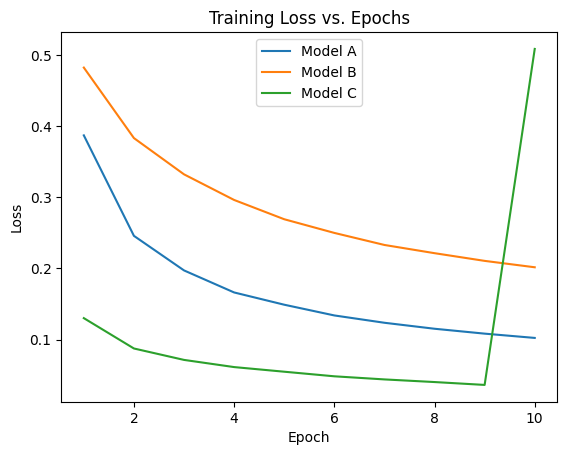

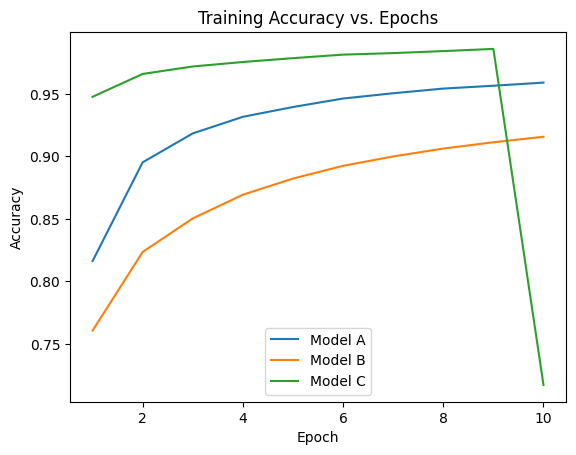

Ensemble (Majority Voting) Test Accuracy: 94.87%
Ensemble Test Accuracy: 0.9487
Confusion Matrix:
 [[17778  1237]
 [  714 18338]]
Classification Report:
               precision    recall  f1-score   support

        Real       0.96      0.93      0.95     19015
        Fake       0.94      0.96      0.95     19052

    accuracy                           0.95     38067
   macro avg       0.95      0.95      0.95     38067
weighted avg       0.95      0.95      0.95     38067



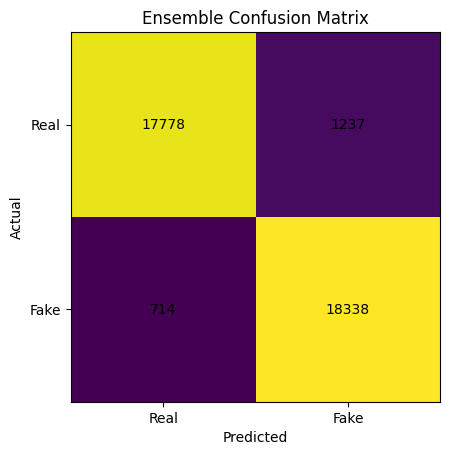

In [41]:
def main():
    # Check device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # -------------------------------
    # Load the dataset using Hugging Face datasets
    # -------------------------------
    hf_dataset = load_dataset('Hemg/deepfake-and-real-images', split="train")
    # For demonstration, use a subset (e.g., first 1000 samples)

    # -------------------------------
    # Create PyTorch Datasets for different input sizes
    # -------------------------------
    dataset_small = DeepfakeDataset(hf_dataset, transform=transform_small)
    dataset_large = DeepfakeDataset(hf_dataset, transform=transform_large)
    
    # Split datasets into train and test (80/20 split)
    n_total = len(dataset_small)
    n_train = int(0.8 * n_total)
    n_test = n_total - n_train
    train_small, test_small = torch.utils.data.random_split(dataset_small, [n_train, n_test])
    train_large, test_large = torch.utils.data.random_split(dataset_large, [n_train, n_test])

    train_loader_small = DataLoader(train_small, batch_size=32, shuffle=True, num_workers=2)
    test_loader_small = DataLoader(test_small, batch_size=32, shuffle=False, num_workers=2)

    train_loader_large = DataLoader(train_large, batch_size=32, shuffle=True, num_workers=2)
    test_loader_large = DataLoader(test_large, batch_size=32, shuffle=False, num_workers=2)

    # -------------------------------
    # Initialize models, loss function, and optimizers
    # -------------------------------
    num_classes = 2
    modelA = ModelA(num_classes=num_classes).to(device)
    modelB = ModelB(num_classes=num_classes).to(device)
    modelC = ModelC(num_classes=num_classes).to(device)

    criterion = nn.CrossEntropyLoss()

    optimizerA = optim.Adam(modelA.parameters(), lr=1e-4)
    optimizerB = optim.Adam(modelB.parameters(), lr=1e-4)
    optimizerC = optim.Adam(modelC.parameters(), lr=1e-4)

    print("Training Model A (CNN-based - Model A, 12 layers, small images)...")
    modelA, lossA, accA = train_model(modelA, train_loader_small, criterion, optimizerA, device, num_epochs=10)

    print("Training Model B (Simpler CNN-based - Model B, small images)...")
    modelB, lossB, accB = train_model(modelB, train_loader_small, criterion, optimizerB, device, num_epochs=10)

    print("Training Model C (CNN + ViT based - large images)...")
    modelC, lossC, accC = train_model(modelC, train_loader_large, criterion, optimizerC, device, num_epochs=10)

    # After training all three:
    epochs = list(range(1, 11))

    plt.figure()
    plt.plot(epochs, lossA, label='Model A')
    plt.plot(epochs, lossB, label='Model B')
    plt.plot(epochs, lossC, label='Model C')
    plt.title('Training Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, accA, label='Model A')
    plt.plot(epochs, accB, label='Model B')
    plt.plot(epochs, accC, label='Model C')
    plt.title('Training Accuracy vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # -------------------------------
    # Evaluate models on the test set
    # -------------------------------
    preds_A, labels = evaluate_model(modelA, test_loader_small, device)
    preds_B, _ = evaluate_model(modelB, test_loader_small, device)
    preds_C, _ = evaluate_model(modelC, test_loader_large, device)  # using large images for model C

    # -------------------------------
    # Ensemble: Majority Voting
    # -------------------------------
    # Ensure predictions arrays have the same length.
    # (Here, we assume that test loaders are synchronized; otherwise, adjust accordingly.)
    predictions = majority_vote([preds_A, preds_B, preds_C])
    accuracy = np.mean(predictions == labels)
    print(f"Ensemble (Majority Voting) Test Accuracy: {accuracy * 100:.2f}%")

    from sklearn.metrics import confusion_matrix, classification_report

    # ... after predictions = majority_vote(...)
    accuracy = np.mean(predictions == labels)
    print(f"Ensemble Test Accuracy: {accuracy:.4f}")

    # Confusion matrix
    cm = confusion_matrix(labels, predictions)
    print("Confusion Matrix:\n", cm)

    # Detailed metrics
    print("Classification Report:\n",
      classification_report(labels, predictions, target_names=['Real','Fake']))

    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title('Ensemble Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0,1], ['Real','Fake'])
    plt.yticks([0,1], ['Real','Fake'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j], ha='center', va='center')
    plt.show()


    torch.save(modelA.state_dict(), 'modelA.pth')
    torch.save(modelB.state_dict(), 'modelB.pth')
    torch.save(modelC.state_dict(), 'modelC.pth')

    # Optionally save the entire ensemble config:
    import json
    with open('ensemble_config.json','w') as f:
        json.dump({
        "models": ["modelA.pth","modelB.pth","modelC.pth"],
        "accuracy": accuracy
        }, f)

if __name__ == "__main__":
    main()